<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Preprocessing

In [ ]:
import pandas as pd
import datetime

def str_to_datetime(s):
    """ Converts a string object to the respective datetime objects"""

    year, month, day = [int(i) for i in s.split('-')]
    return datetime.datetime(year=year, month=month, day=day)


price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price",
}

def load_df(filename):
    """
    Create dataframe, filter only Price column,
    convert date to datetime and make it the index
    """

    df = pd.read_csv(filename)
    df.rename(columns = price_dict, inplace = True)

    # Univariate analysis
    df = df[["Date", "Price"]]

    # Convert date type objects to datetime object
    df["Date"] = df["Date"].apply(str_to_datetime)

    # Turn "Date" Column into dataframe index
    df.index = df.pop("Date")

    return df


df = load_df("MSFT.csv")

df

,Price
Date,
1986-03-13,0.060396
1986-03-14,0.062553
1986-03-17,0.063632
1986-03-18,0.062014
1986-03-19,0.060936
...,...
2023-11-01,346.070007
2023-11-02,348.320007
2023-11-03,352.799988


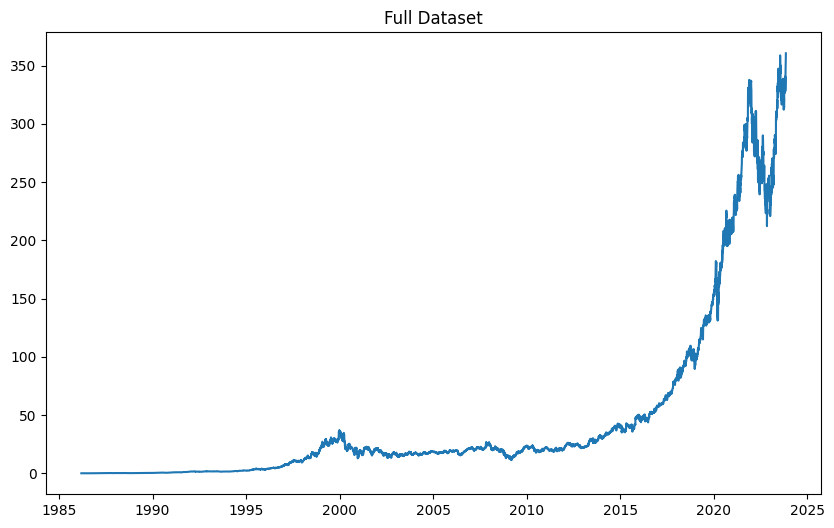

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.title("Full Dataset")
plt.show()

In [ ]:
# Choose the amount of days to consider from the dataset
days = 4500 # ~12 years

# numbers of days to consider in the input of the model
lookback = 14 # 2 weeks


def df_to_windowed(fullDF, n=lookback, daysSelected=days):
    """
    Create a windowed Dataframe (converting into a supervised problem).
    Therefore, the last {lookback} days prices will be the (input)
    and will generate the next day price (output)
    """

    tmp_df = pd.DataFrame()
    for i in range(n, 0, -1):
        tmp_df[f"Last-{i} Price"] = fullDF["Price"].shift(periods=i)
    tmp_df["Price"] = fullDF["Price"]

    return tmp_df.dropna()[-daysSelected:]


windowed_df = df_to_windowed(df)

windowed_df

,Last-14 Price,Last-13 Price,Last-12 Price,Last-11 Price,Last-10 Price,Last-9 Price,Last-8 Price,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,,,,,,,,
2005-12-21,19.777220,19.862316,19.748848,19.635393,19.677940,19.635393,19.649576,19.465212,19.238297,19.209927,19.089373,19.075195,19.025558,19.046831,18.954647
2005-12-22,19.862316,19.748848,19.635393,19.677940,19.635393,19.649576,19.465212,19.238297,19.209927,19.089373,19.075195,19.025558,19.046831,18.954647,18.855370
2005-12-23,19.748848,19.635393,19.677940,19.635393,19.649576,19.465212,19.238297,19.209927,19.089373,19.075195,19.025558,19.046831,18.954647,18.855370,18.890823
2005-12-27,19.635393,19.677940,19.635393,19.649576,19.465212,19.238297,19.209927,19.089373,19.075195,19.025558,19.046831,18.954647,18.855370,18.890823,18.763184
2005-12-28,19.677940,19.635393,19.649576,19.465212,19.238297,19.209927,19.089373,19.075195,19.025558,19.046831,18.954647,18.855370,18.890823,18.763184,18.713545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,331.160004,327.730011,332.640015,332.059998,330.109985,331.320007,326.670013,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007
2023-11-02,327.730011,332.640015,332.059998,330.109985,331.320007,326.670013,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007
2023-11-03,332.640015,332.059998,330.109985,331.320007,326.670013,329.320007,330.529999,340.670013,327.890015,329.809998,337.309998,338.109985,346.070007,348.320007,352.799988


In [ ]:
windowed_df["Price"].describe()

count    4500.000000
mean       87.643239
std        95.270569
min        11.327569
25%        21.380519
50%        38.365381
75%       121.834919
max       360.529999
Name: Price, dtype: float64

## Models

In [ ]:
import os
# If you want to disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model input: (last {lookback} days prices, 1 feature = "price")
models = [
    Sequential([ # Kernel = 3 (Best Model so far)
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPooling1D(pool_size=2, padding="same"),
        layers.LSTM(128, activation="tanh"),
        layers.Dropout(0.05),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Kernel = 3, 1 more dense layer
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPooling1D(pool_size=2, padding="same"),
        layers.LSTM(128, activation="tanh"),
        layers.Dropout(0.05),
        layers.Dense(128),
        layers.Dropout(0.05),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Kernel = 2
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=2, activation="relu", padding="same"),
        layers.MaxPooling1D(pool_size=2, padding="same"),
        layers.LSTM(128, activation="tanh"),
        layers.Dropout(0.05),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Sem CNN
        layers.Input((lookback, 1)),
        layers.LSTM(128, activation="tanh"),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Sem LSTM
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPooling1D(pool_size=2, padding="same"),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Rede Neural Simples
        layers.Input((lookback, 1)),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(1)
    ]),
]

2023-11-19 18:57:15.882226: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 18:57:15.882265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 18:57:15.882278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 18:57:15.887056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 18:57:16.956197: E tensorflow/compiler/

In [ ]:
for model in models:
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 128)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

## Model Training

### Auxilary Functions

In [ ]:
# For each year, 70% train, 10% validation, 20% test
def sliding_window_generator(windowed, trainSize=1260, valiSize=180, testSize=360, step=90):
    """
    Sliding Window Generator
    """

    for i in range(0, len(windowed) - trainSize - testSize - valiSize + 1, step):
        train_slice = windowed[i : i+trainSize]
        vali_slice = windowed[i+trainSize : i+trainSize+valiSize]
        test_slice = windowed[i+trainSize+valiSize : i+trainSize+valiSize+testSize]
        yield (train_slice, vali_slice, test_slice)

Number of Windows:  31


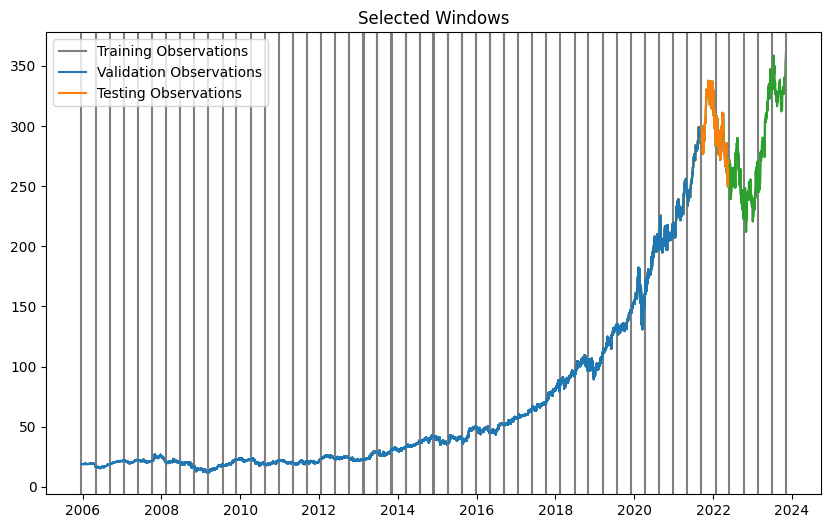

In [ ]:
# Plot windows' intervals and count numbers of windows
plot_generator = sliding_window_generator(windowed_df)
plt.figure(figsize=(10,6))
plt.title("Selected Windows")
windows_cnt = 0
for train, vali, test in plot_generator:
    plt.axvline(train.index[0], color="tab:gray")
    plt.plot(train.index, train["Price"], color="tab:blue")
    plt.plot(vali.index, vali["Price"], color="tab:orange")
    plt.plot(test.index, test["Price"], color="tab:green")
    plt.axvline(test.index[-1], color="tab:gray")
    windows_cnt += 1
plt.legend([
    "Training Observations",
    "Validation Observations",
    "Testing Observations",
])
print("Number of Windows: ", windows_cnt)
plt.show()

In [ ]:
def split_xy(windowedNP):
    """
    Split np.array into X and y
    """

    X = windowedNP[:, :-1]
    y = windowedNP[:, -1]
    return (X, y)

### Main Function

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def cross_validation_score(model, generator, model_idx, flag_plot=False):
    """
    Calculates the cross validation score ("RMSE", "MAE", "R2")
    """

    cv_score = pd.DataFrame(columns=["RMSE", "MAE", "R2"])

    for i, (train, vali, test) in enumerate(generator):

        # Get Dates
        dates_train, dates_vali, dates_test = [i.index for i in [train, vali, test]]

        # Get Scaled Data
        scaler = StandardScaler()
        X_train_sc, y_train_sc = split_xy(scaler.fit_transform(train))
        X_vali_sc, y_vali_sc = split_xy(scaler.transform(vali))
        X_test_sc, y_test_sc = split_xy(scaler.transform(test))

        # Fit and Predict
        model.fit(
            X_train_sc, y_train_sc,
            validation_data=(X_vali_sc, y_vali_sc),
            epochs=80,
            batch_size=32, # slowing performance, improving results
            verbose=False
        )
        preds_sc = model.predict(X_test_sc, verbose=False)

        # Get Non-Scaled Data
        X_train, y_train = split_xy(train.to_numpy())
        X_vali, y_vali = split_xy(vali.to_numpy())
        X_test, y_test = split_xy(test.to_numpy())
        X_result, y_result = split_xy(scaler.inverse_transform(np.hstack((X_test_sc, preds_sc))))

        # Compute Metrics
        rmse = mean_squared_error(y_true=y_test, y_pred=y_result, squared=False)
        mae = mean_absolute_error(y_true=y_test, y_pred=y_result)
        r2 = r2_score(y_true=y_test, y_pred=y_result)

        # Plot Curves and Metrics
        if (flag_plot and (i >= windows_cnt-3)):
            plt.figure(figsize=(10,6))
            plt.plot(dates_train, y_train)
            plt.plot(dates_vali, y_vali)
            plt.plot(dates_test, y_test)
            plt.plot(dates_test, y_result)
            plt.legend([
                "Training Observations",
                "Validation Observations",
                "Testing Observations",
                "Testing Predictions"
            ])
            plt.title(f"Model {model_idx}, Window {i}, RMSE={rmse:.2f}, MAE={mae:.2f}, r2={r2:.2f}")
            plt.show()

        # Append Result
        cv_score.loc[len(cv_score)] = [rmse, mae, r2]

    return cv_score


# For each model, perform a cross validation training,
# plot graphs and compute metrics if wanted
cv_scores = []
for i, model in enumerate(models):
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=0.0001)
    )
    generator = sliding_window_generator(windowed_df)
    cv_score = cross_validation_score(model, generator, i, False)
    cv_scores.append(cv_score)

## Results

In [ ]:
# Output summary (mean, std, min, max)
for i, cv_score in enumerate(cv_scores):
    print(f"Model {i}")
    print(cv_score.describe(), "\n\n")

Model 0
            RMSE        MAE         R2
count  31.000000  31.000000  31.000000
mean    6.481944   5.306590   0.780455
std     6.412175   5.362411   0.195768
min     0.327901   0.248569   0.254893
25%     1.329945   0.980123   0.674138
50%     5.043589   4.039893   0.824332
75%     8.019370   6.769937   0.958031
max    23.068120  20.067376   0.979877 


Model 1
            RMSE        MAE         R2
count  31.000000  31.000000  31.000000
mean    6.832604   5.639469   0.789345
std     7.124858   6.043433   0.193954
min     0.334104   0.248035   0.130720
25%     1.204580   0.899392   0.684237
50%     4.378393   3.338108   0.845866
75%     9.846153   8.135356   0.950971
max    24.695805  22.346994   0.985650 


Model 2
            RMSE        MAE         R2
count  31.000000  31.000000  31.000000
mean    6.851611   5.662163   0.801328
std     7.971758   6.883314   0.204617
min     0.325689   0.240328   0.088889
25%     1.119863   0.815197   0.730862
50%     3.135603   2.383697   0.87

In [ ]:
# Output complete results
for i, cv_score in enumerate(cv_scores):
    print(f"Model {i}")
    print(cv_score)

Model 0
         RMSE        MAE        R2
0    0.329708   0.248569  0.964400
1    0.327901   0.249425  0.968072
2    0.464570   0.334119  0.963088
3    0.649262   0.504013  0.965873
4    1.147615   0.947382  0.907538
5    2.436175   1.917470  0.702524
6    2.826583   2.486624  0.361499
7    1.129294   0.950418  0.824332
8    2.940329   2.518292  0.254893
9    2.586040   2.096322  0.645447
10   0.870634   0.668478  0.960268
11   1.082023   0.883104  0.953513
12   2.136947   1.843262  0.863658
13   2.934439   2.422351  0.836747
14   1.512274   1.009828  0.975679
15   5.043589   4.039893  0.814538
16   8.520106   7.195937  0.596307
17   7.067886   6.343937  0.515441
18   6.855391   5.632523  0.708961
19   7.518634   6.322362  0.748006
20   9.889165   7.574422  0.782631
21  15.601373  11.676665  0.658120
22  17.371449  14.210964  0.661235
23  23.068120  20.067376  0.418344
24  13.915426  10.932214  0.828695
25  18.895102  14.955103  0.801680
26  18.696563  16.770124  0.687041
27   7.14384